### CatBoost modeling - Classification (분류)

In [1]:
# 필요한 기본 package 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0630.git

Cloning into 'DX-Training-LGES-0630'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 92 (delta 8), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (92/92), done.


#### (1) 마케팅 성공 여부(0, 1) 예측/분류

In [3]:
'''
Bank Marketing Data : 포르투칼 은행의 전화 마케팅 데이터, 전화 마케팅의 성공 여부를 고객의 개인정보를 이용해 예측
'''

# 데이터 불러오기
csv = pd.read_csv("/content/DX-Training-LGES-0630/Data/Data_GBM_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [4]:
#전처리 된 데이터 만들기
'''
연속형 변수 정수형 -> 실수형
범주형 변수 -> Dummie Coding
'''

data = pd.DataFrame()

for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()): #데이터의 컬럼과 해당 컬럼의 데이터 타입을 for 문에 입력
    #해당 컬럼의 데이터 타입이 연속형(정수형)일 경우,
    if j[1] == "int64":
        #실수형으로 바꾼 컬럼을 data 변수에 추가
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    #해당 컬럼의 데이터 타입이 범주형일 경우,
    else:
        #Dummies 코딩 수행
        dummies = pd.get_dummies(csv.iloc[:, i])
        dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        #Dummie 코딩한 컬럼을 data에 저장
        data = pd.concat([data, dummies], axis = 1, sort = False)

#종속 변수 "yes"와 "no"를 실수형으로 형태 변경
data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

In [5]:
# 변경된 데이터 확인 (첫 10개의 instances)
data.head(10)

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month_sep,duration,campaign,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,58.0,0,0,0,0,1,0,0,0,0,...,0,261.0,1.0,-1.0,0.0,0,0,0,1,-1.0
1,44.0,0,0,0,0,0,0,0,0,0,...,0,151.0,1.0,-1.0,0.0,0,0,0,1,-1.0
2,33.0,0,0,1,0,0,0,0,0,0,...,0,76.0,1.0,-1.0,0.0,0,0,0,1,-1.0
3,47.0,0,1,0,0,0,0,0,0,0,...,0,92.0,1.0,-1.0,0.0,0,0,0,1,-1.0
4,33.0,0,0,0,0,0,0,0,0,0,...,0,198.0,1.0,-1.0,0.0,0,0,0,1,-1.0
5,35.0,0,0,0,0,1,0,0,0,0,...,0,139.0,1.0,-1.0,0.0,0,0,0,1,-1.0
6,28.0,0,0,0,0,1,0,0,0,0,...,0,217.0,1.0,-1.0,0.0,0,0,0,1,-1.0
7,42.0,0,0,1,0,0,0,0,0,0,...,0,380.0,1.0,-1.0,0.0,0,0,0,1,-1.0
8,58.0,0,0,0,0,0,1,0,0,0,...,0,50.0,1.0,-1.0,0.0,0,0,0,1,-1.0
9,43.0,0,0,0,0,0,0,0,0,0,...,0,55.0,1.0,-1.0,0.0,0,0,0,1,-1.0


In [6]:
# 학습 데이터와 테스트 데이터 구분
# 학습 데이터 비율: 0.7, 테스트 데이터 비율: 0.3
train_data, test_data = train_test_split(data, train_size = 0.7)

# 독립변수(Xs)와 종속변수(Y) 구분
train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y에 종속변수 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y에 종속변수 따로 저장

In [7]:
'''
설치하기 : https://catboost.ai/docs/concepts/python-installation.html

로컬 PC에서 설치 시, 아래의 Code 사용
conda config --add channels conda-forge
conda install catboost
'''
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [8]:
'''
파라미터 목록 : https://catboost.ai/docs/concepts/python-reference_parameters-list.html
'''
# CatBoost 모델(분류) package 불러오기
from catboost import CatBoostClassifier

# CatBoost 모델 생성하기
model = CatBoostClassifier(objective = 'Logloss',
                           iterations= 100,
                           learning_rate = 0.1,
                           max_depth = 6,
                           num_leaves = 31,
                           colsample_bylevel = 0.7,
                           verbose=True)

# 모델에 데이터 fitting (학습)
model.fit(train_X, train_Y)

0:	learn: 0.5872525	total: 56.8ms	remaining: 5.63s
1:	learn: 0.4988801	total: 66.4ms	remaining: 3.25s
2:	learn: 0.4335926	total: 76.5ms	remaining: 2.47s
3:	learn: 0.3920671	total: 86.6ms	remaining: 2.08s
4:	learn: 0.3523537	total: 96.1ms	remaining: 1.82s
5:	learn: 0.3246812	total: 106ms	remaining: 1.65s
6:	learn: 0.3068962	total: 115ms	remaining: 1.53s
7:	learn: 0.2928127	total: 125ms	remaining: 1.44s
8:	learn: 0.2846048	total: 137ms	remaining: 1.38s
9:	learn: 0.2754278	total: 146ms	remaining: 1.32s
10:	learn: 0.2669256	total: 156ms	remaining: 1.26s
11:	learn: 0.2595051	total: 165ms	remaining: 1.21s
12:	learn: 0.2544628	total: 174ms	remaining: 1.17s
13:	learn: 0.2490612	total: 184ms	remaining: 1.13s
14:	learn: 0.2465557	total: 193ms	remaining: 1.09s
15:	learn: 0.2422618	total: 203ms	remaining: 1.07s
16:	learn: 0.2393356	total: 212ms	remaining: 1.03s
17:	learn: 0.2369786	total: 222ms	remaining: 1.01s
18:	learn: 0.2345830	total: 231ms	remaining: 985ms
19:	learn: 0.2326109	total: 265ms	re

In [9]:
# 학습한 CatBoost 모델을 통해 테스트 데이터 예측
# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

pred.head(10)

,y,pred
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,1.0,1.0
4,-1.0,-1.0
5,1.0,1.0
6,-1.0,-1.0
7,1.0,1.0
8,-1.0,-1.0
9,-1.0,-1.0


In [10]:
# Confusion Matrix 생성
tab = pd.crosstab(pred.y, pred.pred)

# 정확도 구하기
acc = (tab.iloc[0,0] + tab.iloc[1,1]) / len(test_Y)

print("Confusion Matrix")
print(tab)
print("   ")
print("Acc : ", acc)

Confusion Matrix
pred   -1.0   1.0
y                
-1.0  11607   318
 1.0    946   693
   
Acc :  0.9068121498083161


#### (2) 가입자 이탈 여부 예측/분류

In [11]:
'''
가입자 이탈/이탈률 dataset : 전체 19개 피처와 1개의 타겟으로 구성 (Categorical feature: State, Area_code, Int.l.Plan, VMail.Plan)

타겟명: 'Churn.' / True(1)는 이탈한 고객, False(0)는 이탈하지 않은 고객을 의미함
'''

# 데이터 불러오기
churn = pd.read_csv("/content/DX-Training-LGES-0630/Data/Data_GBM_churn.csv")
print('dataset shape:', churn.shape)

# 데이터 확인 (첫 3개 instances)
churn.head(3)

dataset shape: (3333, 20)


,State,Account.Length,Area.Code,Int.l.Plan,VMail.Plan,VMail.Message,Day.Mins,Day.Calls,Day.Charge,Eve.Mins,Eve.Calls,Eve.Charge,Night.Mins,Night.Calls,Night.Charge,Intl.Mins,Intl.Calls,Intl.Charge,CustServ.Calls,Churn.
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.


In [12]:
#데이터 전처리

# column name 중 "."을 "_"으로 변경
churn.columns = churn.columns.str.replace(".","_")

# data 중 Area.Code는 지역숫자로 수치형이 아니기 때문에, category로 변경
churn.Area_Code = churn.Area_Code.astype("category")

# 독립변수(Xs)와 종속변수(Y) 구분
y_labels = "Churn_" # y_labels에는 타겟 column name 할당
X_features = churn.columns[churn.columns != y_labels].tolist() # X_features에 그 외 column name 할당

# set X_features and y_labels for CatBoost
X_features = churn.drop(['Churn_'], axis=1)
y_labels = churn['Churn_']

# 타겟 변수에 대해 불만족한 고객 ('True.')을 1로, 나머지는 0으로 해서 최종적으로 binary class {1, 0}로 변경
# CatBoost package needs {1, 0} target values for binary classification
y_labels = np.where(y_labels == "True.", 1, 0)

# 학습 데이터와 테스트 데이터 구분 (비율 8:2)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, train_size=0.8, test_size = 0.2, random_state=0)

In [13]:
from catboost import CatBoostClassifier, Pool

# CatBoost 수행 시간 측정을 위해, 시작 시간 설정
start_time = time.time()

# dataframe에서 category, object 형식의 column의 위치를 출력
cat_features = np.where(X_features.dtypes.astype("str").isin(["category","object"]))[0]

# 모델 설정 및 train dataset으로 fitting (학습)
CatBoost = CatBoostClassifier(random_seed = 0)
CatBoost.fit(X = X_train, y = y_train, cat_features = cat_features, eval_set=[(X_test, y_test)])

# CatBoost 실험 종료에 대한 시간 측정
CatBoost_time = time.time() - start_time

Learning rate set to 0.040374
0:	learn: 0.6466748	test: 0.6479830	best: 0.6479830 (0)	total: 8.79ms	remaining: 8.79s
1:	learn: 0.6127407	test: 0.6144335	best: 0.6144335 (1)	total: 16.6ms	remaining: 8.28s
2:	learn: 0.5815302	test: 0.5835429	best: 0.5835429 (2)	total: 24.4ms	remaining: 8.1s
3:	learn: 0.5448342	test: 0.5473620	best: 0.5473620 (3)	total: 31.7ms	remaining: 7.9s
4:	learn: 0.5223426	test: 0.5235789	best: 0.5235789 (4)	total: 39.2ms	remaining: 7.79s
5:	learn: 0.4976320	test: 0.4989093	best: 0.4989093 (5)	total: 46.1ms	remaining: 7.63s
6:	learn: 0.4788748	test: 0.4800562	best: 0.4800562 (6)	total: 53.1ms	remaining: 7.54s
7:	learn: 0.4652043	test: 0.4653911	best: 0.4653911 (7)	total: 57ms	remaining: 7.07s
8:	learn: 0.4425578	test: 0.4422055	best: 0.4422055 (8)	total: 64.2ms	remaining: 7.07s
9:	learn: 0.4257498	test: 0.4250169	best: 0.4250169 (9)	total: 71.5ms	remaining: 7.08s
10:	learn: 0.4100008	test: 0.4092929	best: 0.4092929 (10)	total: 78.9ms	remaining: 7.09s
11:	learn: 0.39

In [14]:
# feature와 target 변수를 합하여 data frame 재구성
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# 학습한 CatBoost 모델을 통해 테스트 데이터를 예측하고, 그 결과를 AUC 및 정확도 기준으로 평가
CatBoost_eval = CatBoost.eval_metrics(test_pool, ['AUC','Accuracy'], plot=False)
maxAUC_index = np.argmax(CatBoost_eval['AUC'])

CatBoost_AUC = CatBoost_eval['AUC'][maxAUC_index]
CatBoost_Accuracy = CatBoost_eval['Accuracy'][maxAUC_index]

In [15]:
print(CatBoost_AUC)
print(CatBoost_Accuracy)

0.932053697597739
0.9580209895052474


> Accuracy

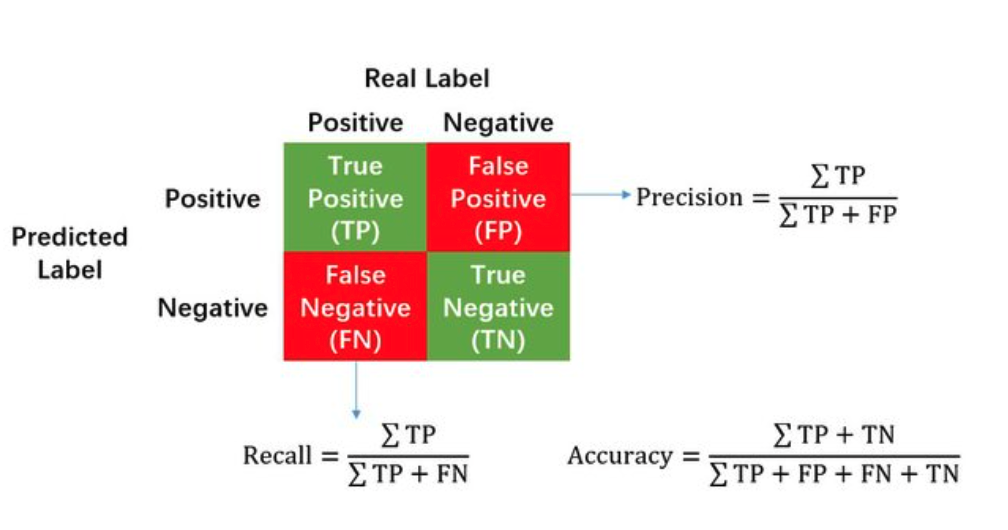

> AUC

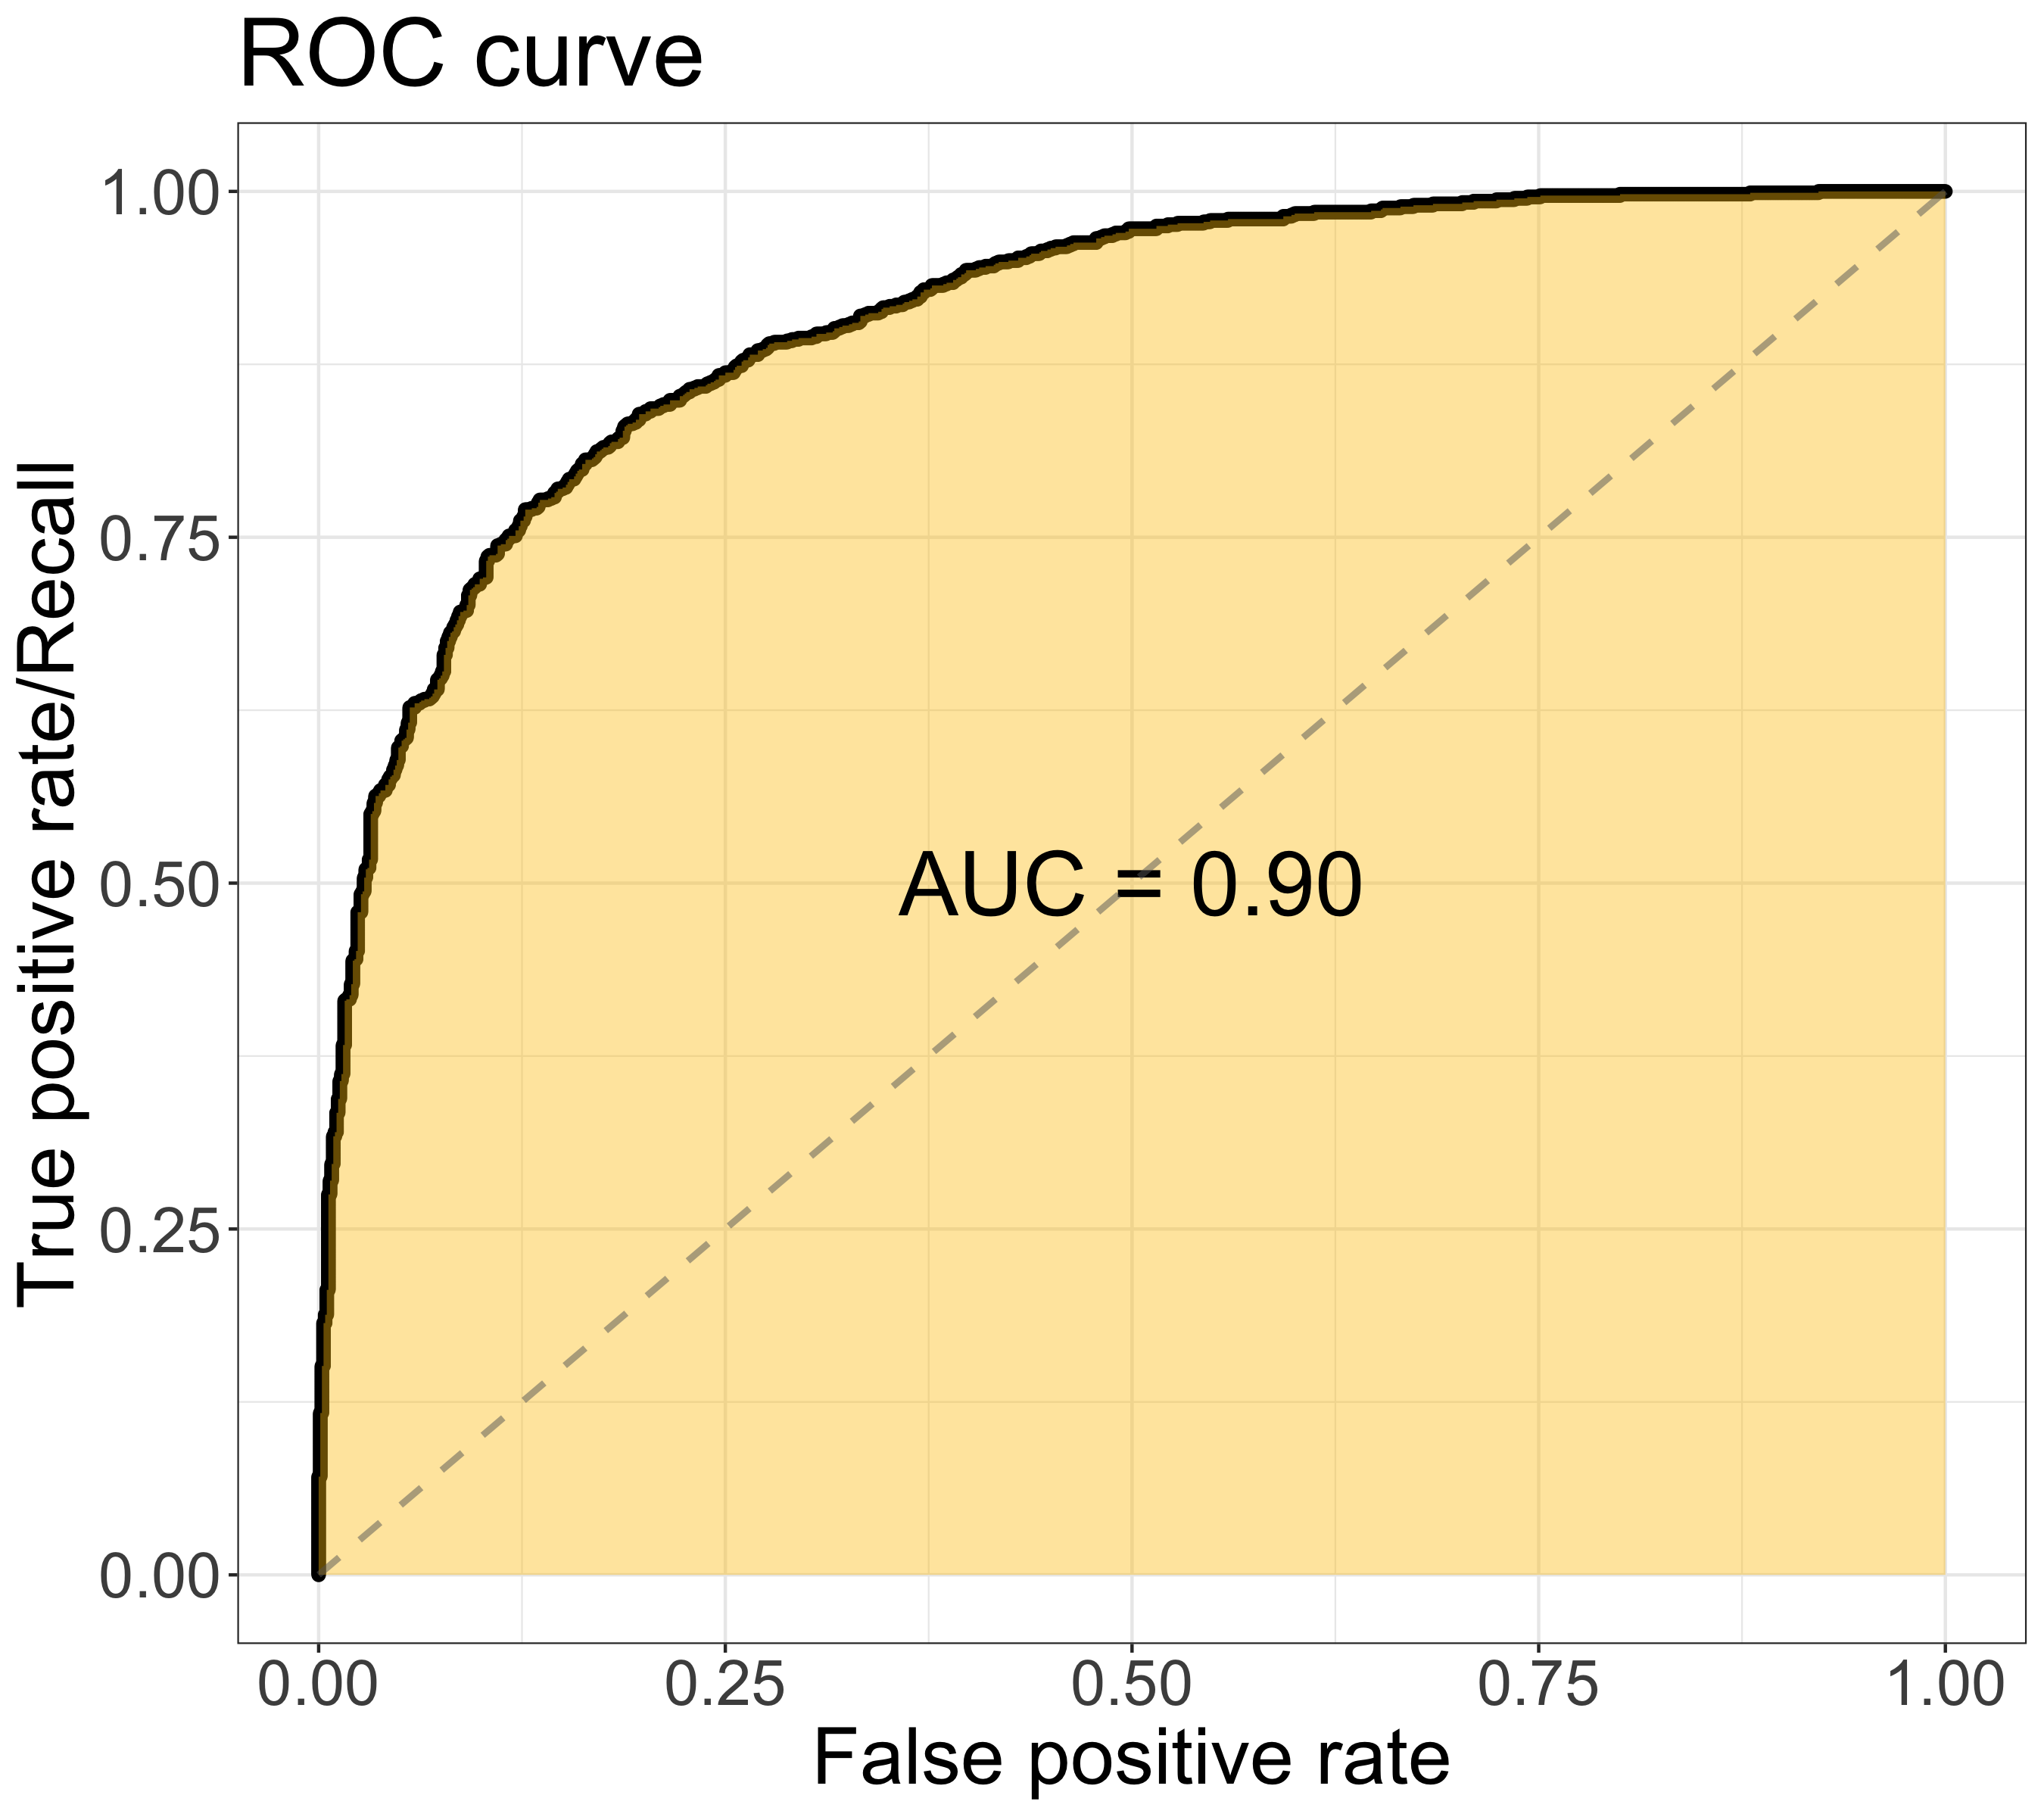